In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/malaria.zip" -d "/content/sample_data/Dataset"  

Archive:  /content/drive/My Drive/malaria.zip
   creating: /content/sample_data/Dataset/malaria/
  inflating: /content/sample_data/Dataset/malaria/training.json  
   creating: /content/sample_data/Dataset/__MACOSX/
   creating: /content/sample_data/Dataset/__MACOSX/malaria/
  inflating: /content/sample_data/Dataset/__MACOSX/malaria/._training.json  
   creating: /content/sample_data/Dataset/malaria/images/
  inflating: /content/sample_data/Dataset/malaria/images/027ab174-e47a-44f8-b85b-372449eeb7d8.png  
   creating: /content/sample_data/Dataset/__MACOSX/malaria/images/
  inflating: /content/sample_data/Dataset/__MACOSX/malaria/images/._027ab174-e47a-44f8-b85b-372449eeb7d8.png  
  inflating: /content/sample_data/Dataset/malaria/images/b1145408-feae-4637-b4cf-3e70b99cc62d.png  
  inflating: /content/sample_data/Dataset/__MACOSX/malaria/images/._b1145408-feae-4637-b4cf-3e70b99cc62d.png  
  inflating: /content/sample_data/Dataset/malaria/images/351d6536-3a5c-46eb-a6e4-d71dd999908a.jpg  
 

In [3]:
import os
import json 
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

import cv2 
from sklearn.model_selection import train_test_split
import pandas as pd

import copy
import time

! pip uninstall imgaug 
! pip install git+https://github.com/aleju/imgaug.git 
! pip install bbaug 

import imgaug, bbaug

Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.6/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-8f0s17wh
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-8f0s17wh
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971106 sha256=425d515cf55ba526d7b5bd49286bd87100af8b91a513a19c3a6af017861b9e7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-s2d86qqq/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [4]:

#Read data and prepare it for RCNN model
def read_data(file_name, path = "/content/sample_data/Dataset/malaria"):

  all_label = ['leukocyte','ring', 'schizont', 'gametocyte']
  rare_label = []
  categories= {'leukocyte':1, 'red blood cell':2, 'trophozoite':3, 'ring':4, 'schizont':5, 'difficult':7, 'gametocyte':6}
  f = open(path+"/"+file_name,) 
  data = json.load(f) 
  
  images =  []
  labels = []
  labelss = []
  boxes = []
  temp = []

  print('number of data: ',len(data))
  final_data = []
  mydf = pd.DataFrame()
  for n, img in enumerate(data):
    # if n ==10 :
    #   break
    bbb = []
    ll = []
    image = cv2.imread(path+img['image']['pathname'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    w , h = image.shape[:2]
    image = resize(image, (128, 170), mode='constant', preserve_range=True)
    image /= 255
    images.append(image) 
    scale1 = w/128
    scale2 = h/170
    new_image7 = copy.copy(image[:,:,0])
    new_image7[:,:] = 0
   
    
    for i in img['objects']:
      bb = i['bounding_box']
      new_image7[slice(int(bb['minimum']['r']/scale1),int(bb['maximum']['r']/scale1)),slice(int(bb['minimum']['c']/scale2),int(bb['maximum']['c']/scale2))] = 255
      bbb.append(np.array([bb['minimum']['c']/scale2,bb['minimum']['r']/scale1,bb['maximum']['c']/scale2,bb['maximum']['r']/scale1]))
      ll.append(categories[i['category']])
      # print(i['category'])
      if i['category'] in all_label:
        rare_label.append(n)

    ll = np.array(ll)    
    labelss.append(ll)

    boxes.append(np.array(bbb))
    temp.append((image, new_image7))
    
  labelss = np.array(labelss)
  boxes = np.array(boxes)
  
  print(labelss.shape)
  print(boxes.shape)
  

  return labelss, images, boxes, temp, rare_label


labelss, images, boxes, t, rare_index= read_data('training.json')
labelss_test, images_test, boxes_test, t, _= read_data('test.json')
rare_index = set(rare_index)
print(rare_index)
# plt.imshow(images[0])
# 

number of data:  1208


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(1208,)
(1208,)
number of data:  120
(120,)
(120,)
{2, 3, 4, 6, 8, 9, 13, 14, 15, 17, 20, 21, 22, 23, 29, 32, 40, 41, 47, 48, 50, 51, 53, 54, 56, 59, 63, 65, 69, 70, 72, 74, 77, 78, 82, 86, 88, 90, 93, 95, 98, 101, 102, 110, 111, 112, 115, 117, 119, 120, 129, 134, 135, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 152, 157, 158, 159, 160, 161, 167, 168, 169, 172, 173, 174, 178, 180, 181, 184, 185, 186, 187, 193, 195, 196, 197, 200, 201, 206, 207, 209, 212, 213, 214, 216, 217, 219, 220, 222, 224, 225, 229, 234, 236, 238, 242, 245, 247, 248, 249, 251, 252, 255, 257, 259, 262, 263, 264, 267, 268, 273, 274, 275, 276, 278, 282, 285, 287, 288, 289, 290, 291, 292, 293, 295, 296, 302, 305, 306, 310, 314, 315, 317, 325, 328, 330, 335, 337, 338, 342, 345, 346, 347, 349, 351, 352, 355, 360, 361, 362, 363, 365, 366, 367, 368, 370, 371, 375, 376, 379, 380, 381, 382, 383, 384, 386, 387, 388, 390, 392, 394, 398, 400, 401, 402, 403, 404, 407, 408, 409, 412, 414, 416, 417, 419, 421, 424, 425, 426, 

In [18]:
from bbaug import policies

def agumente_img(aug_polic, images, bbs, labels):
  
  policy_container = policies.PolicyContainer(aug_policy)
  random_policy = policy_container.select_random_policy() 
  new_images = []
  new_bbs = []
  new_labels = []
  
  for img, bb, l in zip(images, bbs, labels):
    img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, img, bb, l)
    new_images.append(img_aug)
    new_bbs.append(np.array([np.array(i[1:]) for i in bbs_aug]))
    new_labels.append(np.array([i[0] for i in bbs_aug]))

  
  new_bbs = np.array(new_bbs)
  new_labels = np.array(new_labels)
  new_images = np.array(new_images)

  print("img: ", new_images.shape)
  print("bbs: ", new_bbs.shape)
  print("labels: ", new_labels.shape)

  return new_images, new_labels, new_bbs
  

aug_policy = policies.policies_v1()
print(len(aug_policy))
rare_images = [images[i] for i in rare_index]
rare_lables = [labelss[i] for i in rare_index]
rare_boxes = [boxes[i] for i in rare_index]

# new_images1, new_labels1, new_bbs1 = agumente_img(aug_policy[:10], rare_images, rare_boxes, rare_lables)
new_images2, new_labels2, new_bbs2 = agumente_img(aug_policy[10:], rare_images, rare_boxes, rare_lables)


20
img:  (564, 128, 170, 3)
bbs:  (564,)
labels:  (564,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [19]:
print(new_images1.shape)
print(new_bbs1.shape)
print(new_labels1.shape)

print(new_images2.shape)
print(new_bbs2.shape)
print(new_labels2.shape)


(564, 128, 170, 3)
(564,)
(564,)
(564, 128, 170, 3)
(564,)
(564,)


In [20]:
boxes = list(boxes)
labelss = list(labelss)
images_a = [i for i in images]
labelss_a = [i for i in labelss]
boxes_a = [i for i in boxes]

for n in range(len(new_images1)):
  images_a.append(new_images1[n])
  images_a.append(new_images2[n])
  boxes_a.append(new_bbs1[n])
  boxes_a.append(new_bbs2[n])
  labelss_a.append(new_labels1[n])
  labelss_a.append(new_labels2[n])
  
images_a = np.array(images_a)
boxes_a = np.array(boxes_a)
labelss_a = np.array(labelss_a)

print(images_a.shape)
print(boxes_a.shape)
print(labelss_a.shape)


(2336, 128, 170, 3)
(2336,)
(2336,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [21]:

c = list(zip(images_a, boxes_a, labelss_a))
random.shuffle(c)
images_a, boxes_a, labelss_a = zip(*c)

print(np.array(images_a).shape)
print(np.array(boxes_a).shape)
print(np.array(labelss_a).shape)

(2336, 128, 170, 3)
(2336,)
(2336,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [22]:
temp = []
for i in labelss_a:
  for j in i:
    temp.append(j)

labels, counts = np.unique(temp, return_counts=True)
print(counts)

temp = []
for i in labelss_test:
  for j in i:
    temp.append(j)

labels, counts = np.unique(temp, return_counts=True)
print(counts)

[   309 145596   2835   1059    537    432    783]
[5614  111  169   11   12    5]


In [23]:
import torchvision
import torch
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# pre-processing the data
imagess = []
for i in images_a:
  im = []
  im.append(i[:,:,0])
  im.append(i[:,:,1])
  im.append(i[:,:,2])
  imagess.append(im)

images_a = np.array(imagess)
images_a = list(torch.from_numpy(image).float() for image in images_a)
targets = []
for i in range(len(images_a)):
  d = {}
  d['boxes'] = torch.from_numpy(boxes_a[i]).float()
  d['labels'] = torch.from_numpy(np.array([tf.cast(j, tf.int64) for j in labelss_a[i]]))
  targets.append(d)

batch_image = []
bi = []
for n, i in enumerate(images_a):
  bi.append(i)
  if (n+1)%4 == 0:
    batch_image.append(bi)
    bi = []

batch_target = []
bi = []
for n, i in enumerate(targets):
  bi.append(i)
  if (n+1)%4 == 0:
    batch_target.append(bi)
    bi = []



In [24]:
# define the model

t1 = time.time()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress = True)
num_classes = 8  # 7 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to('cuda')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                           patience=3, verbose=True)

num_epochs = 3
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

iterations = 0.0
loss_hist = Averager()
itr = 1
device= 'cuda'

for epoch in range(num_epochs):
  loss_hist.reset()
  
  for img, targets in zip(batch_image,batch_target):
    img = list(image.to(device) for image in img)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(img, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()

    loss_hist.send(loss_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 50 == 0:
        print(f"Iteration #{itr} loss: {loss_value}")

    itr += 1

# update the learning rate
  if lr_scheduler is not None:
      lr_scheduler.step(loss_hist.value)

  print(f"Epoch #{epoch} loss: {loss_hist.value}")

t2 = time.time()
print("training time: ", t2 -t1)


Iteration #50 loss: 0.9253928661346436
Iteration #100 loss: 0.5783864855766296
Iteration #150 loss: 0.548638105392456
Iteration #200 loss: 0.7627501487731934
Iteration #250 loss: 0.6780129671096802
Iteration #300 loss: 0.4817030131816864
Iteration #350 loss: 0.44463595747947693
Iteration #400 loss: 0.43597733974456787
Iteration #450 loss: 0.5309392809867859
Iteration #500 loss: 0.7045894861221313
Iteration #550 loss: 0.46495652198791504
Epoch #0 loss: 0.6278451790344225
Iteration #600 loss: 0.3628599941730499
Iteration #650 loss: 0.42650681734085083
Iteration #700 loss: 0.33022361993789673
Iteration #750 loss: 0.5345249772071838
Iteration #800 loss: 0.52326500415802
Iteration #850 loss: 0.27564504742622375
Iteration #900 loss: 0.40688803791999817
Iteration #950 loss: 0.4196333587169647
Iteration #1000 loss: 0.39406925439834595
Iteration #1050 loss: 0.24148307740688324
Iteration #1100 loss: 0.515249490737915
Iteration #1150 loss: 0.30431249737739563
Epoch #1 loss: 0.41384957878761097
It

In [25]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# drawing bounding box
def bounding_box(img, boxes, labels, title):
  custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']

  fig,ax = plt.subplots(1)
  ax.imshow(img)
  rect = []
  for i,j in zip(boxes, labels):
    rect.append(patches.Rectangle((i[0],i[1]),i[2] - i[0],i[3] - i[1],linewidth=3,edgecolor=custom_colors[j-1],facecolor='none'))
  for i in rect:
    ax.add_patch(i)
  ax.title.set_text(title)
  plt.show()


# bounding_box(img, boxes, labels)


In [27]:
from shapely.geometry import Polygon


def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou


In [28]:
#prediction part
imagess = []
# print(len(images_test_a[0].shape))
for i in images_test:
  im = []
  im.append(i[:,:,0])
  im.append(i[:,:,1])
  im.append(i[:,:,2])
  imagess.append(im)

images_test_1 = np.array(imagess)
images_test_1 = list(torch.from_numpy(image).float() for image in images_test_1)

batch_image_t = []
bi = []
for n, i in enumerate(images_test_1):
  batch_image_t.append([i])

print(len(batch_image_t))
index = 10

images_tt = list(image.to(device) for image in batch_image_t[index])
predictions_t = model(images_tt)

img_one_pred = predictions_t[0] 
boxes = img_one_pred['boxes'].cpu().data.numpy()
labels = img_one_pred['labels'].cpu().data.numpy()
scores = img_one_pred['scores'].cpu().data.numpy()
print(labels.shape)
for n, i in enumerate(scores):
  if i < 0.2:
    break
boxes = boxes[:n]
labels = labels[:n]
print(labels.shape)
first_img = images_tt[0].cpu().data.numpy()
img = np.zeros((128, 170, 3))
img[:,:,0] = first_img[0,:,:]
img[:,:,1] = first_img[1,:,:]
img[:,:,2] = first_img[2,:,:]



120
(56,)
(43,)


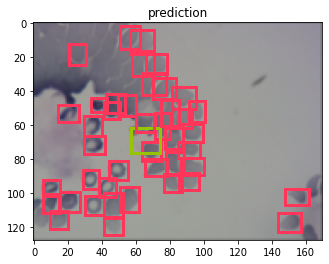

In [29]:
bounding_box(img, boxes, labels, "prediction")

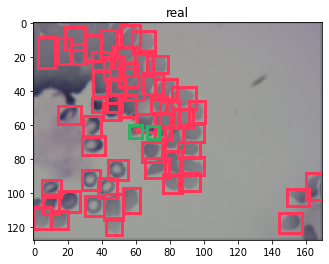

In [30]:
bounding_box(img, boxes_test[index], labelss_test[index], "real")

In [31]:
#calculate IoU for each class

def iou_for_boxes(boxes, labels, boxes_test, labelss_test, index, c, class_num):
  sum = 0
  for i, k  in zip(boxes, labels):
    temp = []
    for j, m in zip(boxes_test[index], labelss_test[index]):
      if m == c and k == c:
        b1 = [[i[0],i[1]],[i[2],i[1]],[i[2],i[3]], [i[0],i[3]]]
        b2 = [[j[0],j[1]],[j[2],j[1]],[j[2],j[3]], [j[0],j[3]]]
        x =  calculate_iou(b1, b2)
        temp.append(x)
    if temp != []:
      sum+=max(temp)
  return sum/class_num


In [32]:
#calculate IoU fro each image and the average it

all = [0,0,0,0,0,0,0,0]
all_class_num = [0,0,0,0,0,0,0,0]

for index in range(0,120):
  images_tt = list(image.to(device) for image in batch_image_t[index])
  predictions_t = model(images_tt)

  img_one_pred = predictions_t[0] 
  boxes = img_one_pred['boxes'].cpu().data.numpy()
  labels = img_one_pred['labels'].cpu().data.numpy()
  scores = img_one_pred['scores'].cpu().data.numpy()
  # for n, i in enumerate(scores):
  #   if i < 0.1:
  #     break
  # boxes = boxes[:n]
  # labels = labels[:n]

  unique_classes = list(set(list(labelss_test[index])))
  for c in unique_classes:
    iou = iou_for_boxes(boxes, labels, boxes_test, labelss_test, index, c, list(labelss_test[index]).count(c))
    all[c-1]+=iou
    all_class_num[c-1]+=1
    print("for image ",index," in test set iou for class ", c, "is :", iou)
print(all)
print(all_class_num)
n = 0
for i, j in zip(all, all_class_num):
  n +=1
  if i == 0:
    print("avg of IoU for class ", n, " is ", 0)
  else:
    print("avg of IoU for class ", n, " is ", i/j)

for image  0  in test set iou for class  2 is : 0.8716186570272291
for image  0  in test set iou for class  3 is : 0.9144608852339979
for image  1  in test set iou for class  2 is : 0.8844024782971776
for image  1  in test set iou for class  4 is : 0.5850564103781498
for image  2  in test set iou for class  2 is : 0.8625640663477342
for image  2  in test set iou for class  3 is : 0.9195421841353013
for image  2  in test set iou for class  4 is : 0.8546615455090029
for image  3  in test set iou for class  2 is : 0.8933187311730753
for image  3  in test set iou for class  5 is : 0.0
for image  4  in test set iou for class  2 is : 0.8569570359667109
for image  4  in test set iou for class  4 is : 0.43741068499361574
for image  5  in test set iou for class  2 is : 0.8239360263681142
for image  5  in test set iou for class  7 is : 0.7396320143363289
for image  6  in test set iou for class  2 is : 0.8746598145554045
for image  6  in test set iou for class  3 is : 1.1909726551146465
for image